# MADE RL and Advanced DL: Домашнее задание 3

https://docs.google.com/document/d/1DIBYLQ755w7z06IslSVzFf3gyiKd8077ZYyzD5TU8ug/

## Часть первая: перенос стиля при помощи pix2pix

В этом задании мы будем реализовывать перенос стиля на спаренных данных (paired data). 

In [17]:
!nvidia-smi

Thu Dec  9 05:59:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    74W / 149W |  10624MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [18]:
import os

if not os.path.isdir('facades'):
  !wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
  !tar -xf facades.tar.gz

In [19]:
!ls facades

test  train  val


In [20]:
import os
from pathlib import Path
import random

import numpy as np
import time
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.datasets as datasets
import torch.optim as optim
from torch.autograd import Variable
from torchvision.utils import make_grid
import torchvision.transforms as transforms
import torchvision
import tqdm

from matplotlib import pyplot as plt
%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [21]:
image_width = image_height = 256
shuffle = True
batch_size = 1
num_workers = 1 

num_epochs = 100

In [22]:
dataset_dir = 'facades'
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')
val_dir = os.path.join(dataset_dir, 'val')

In [23]:
class Dataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(root)))

    def __getitem__(self, idx):

        img_path = os.path.join(self.root, self.imgs[idx])
        img = np.array(Image.open(img_path).convert("RGB"))

        h, w, d = img.shape
        w = w // 2
        original_img = img[:, :w, :]
        input_img = img[:, w:, :]

        if self.transforms is not None:
            input_img = self.transforms(Image.fromarray(input_img))
            original_img = self.transforms(Image.fromarray(original_img))

        return original_img, input_img

    def __len__(self):
        return len(self.imgs)

dataset_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((image_width, image_height)),
    #torchvision.transforms.RandomResizedCrop(image_width),
    torchvision.transforms.RandomAutocontrast(p=0.1),
    torchvision.transforms.RandomHorizontalFlip(p=0.1),
    torchvision.transforms.ToTensor(),
])

In [24]:
train_set = Dataset(root=train_dir, transforms=dataset_transforms)
val_set = Dataset(root=val_dir, transforms=dataset_transforms)
test_set = Dataset(root=test_dir, transforms=dataset_transforms)

train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    shuffle=shuffle,
    num_workers=num_workers
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=batch_size,
    shuffle=shuffle,
    num_workers=num_workers
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    shuffle=shuffle,
    num_workers=num_workers
)

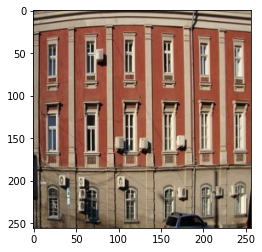

In [25]:
image = train_set[1][0]
mask = train_set[1][1]
im = transforms.ToPILImage()(image)
plt.imshow(im)
plt.show()

## pix2pix

In [26]:
def normal_init(conv, mean, std):
    conv.weight.data.normal_(mean, std)
    conv.bias.data.zero_()  

class DBlock(nn.Module):
    def __init__(self, in_channel, out_channel, batch_norm=True, mean=0.0, std=0.02):
        super(DBlock, self).__init__()
        self.conv = nn.Conv2d(in_channel, out_channel, kernel_size=(4, 4), stride=2, padding=1)
        normal_init(self.conv, mean, std)
        
        self.batch_norm = batch_norm
        if batch_norm:
            self.bn = nn.InstanceNorm2d(out_channel)
    
    def forward(self, x):
        x = self.conv(x)
        if self.batch_norm:
            x = self.bn(x)
        output = F.leaky_relu(x, 0.2)
        return output
    
class UBlock(nn.Module):
    def __init__(self, in_channel, out_channel, dropout=True, batch_norm=True, mean=0.0, std=0.02):
        super(UBlock, self).__init__()
        self.conv_t = nn.ConvTranspose2d(in_channel, out_channel, kernel_size=(4, 4), stride=2, padding=1)
        normal_init(self.conv_t, mean, std)
        
        self.batch_norm = batch_norm
        if self.batch_norm:
            self.batch_norm_layer = nn.InstanceNorm2d(out_channel)
        self.dropout = dropout
        if self.dropout:
            self.dropout_layer = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.conv_t(x)
        if self.batch_norm:
            x = self.batch_norm_layer(x)
        if self.dropout:
            x = self.dropout_layer(x)
        output = F.relu(x)
        return output
    
class UGenerator(nn.Module):
    def __init__(self, mean=0.0, std=0.02):
        super(UGenerator, self).__init__()
        self.dblocks = nn.ModuleList()
        batch_norm = [0, 1, 1, 1, 1, 1, 1, 0]
        dblocks_input = [3, 64, 128, 256, 512, 512, 512, 512]
        dblocks_output = dblocks_input[1:] + [512]
        for i in range(len(dblocks_input)): 
            self.dblocks.append(DBlock(dblocks_input[i], dblocks_output[i], batch_norm=batch_norm[i], mean=mean, std=std))
        
        self.ublocks = nn.ModuleList()
        ublocks_input = [512, 1024, 1536, 1536, 1536, 1280, 640, 320]
        ublocks_output = [512, 1024, 1024, 1024, 1024, 512, 256, 128]
        batch_norm = [1, 1, 1, 1, 1, 1, 1, 1]                      
        for i in range(len(ublocks_input)): 
            self.ublocks.append(UBlock(ublocks_input[i], ublocks_output[i], batch_norm=batch_norm[i], mean=mean, std=std))
            
        self.conv = nn.Conv2d(131, 3, kernel_size=(1, 1))
        normal_init(self.conv, mean, std)
        
    def forward(self, x):
        downsamples = [x]
        for block in self.dblocks:
            downsamples.append(block(downsamples[-1]))
        y = downsamples[-1]
        n = len(downsamples)
        for i, block in enumerate(self.ublocks):
            y = block(y)
            y = torch.cat([y, downsamples[n - 2 - i]], dim=1)
            
        output = torch.tanh(self.conv(y))
        return output
    
class PatchDescriminator(nn.Module):
    def __init__(self, mean=0.0, std=0.02):
        super(PatchDescriminator, self).__init__()
        self.dblocks = nn.ModuleList()
        dblocks_input = [6, 64, 128, 256]
        dblocks_output = dblocks_input[1:] + [512]
        for i in range(len(dblocks_input)): 
            self.dblocks.append(DBlock(dblocks_input[i], dblocks_output[i], batch_norm=(i!=0), mean=mean, std=std))
            
        self.conv = nn.Conv2d(512, 1, kernel_size=(16, 16))
        normal_init(self.conv, mean, std)
    
    def forward(self, x, masks):
        x = torch.cat([x, masks], 1)
        for block in self.dblocks:
            x = block(x)
        x = torch.sigmoid(self.conv(x))
        return x.view((x.shape[0], -1))

In [27]:
def plot_images(images, masks, fakes):
    pil_images = []
    pil_masks = []
    pil_fakes = []
    batch_size = images.shape[0]
    for idx in range(batch_size):
        pil_images.append(transforms.ToPILImage()(images[idx]).convert("RGB"))
        pil_masks.append(transforms.ToPILImage()(masks[idx]).convert("RGB"))
        pil_fakes.append(transforms.ToPILImage()(fakes[idx]).convert("RGB"))
    fig = plt.figure(figsize=(20, 30))
    grid = ImageGrid(fig, 111,
                     nrows_ncols=(3, batch_size),
                     axes_pad=0.5,
                     )
        
    images_to_show = pil_images + pil_masks + pil_fakes

    for ax, im in zip(grid, images_to_show):
        ax.imshow(im)

    plt.show()

In [28]:
netG = UGenerator()
netD = PatchDescriminator()
netG.train()
netD.train()
x = torch.ones((2, 3, 256, 256))
mask = torch.ones((2, 3, 256, 256))

In [29]:
train_dataloader = data.DataLoader(train_set, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, drop_last=True)
test_dataloader = data.DataLoader(test_set, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

lr = 0.0002 
beta1 = 0.5 
beta2 = 0.999
l1_lambda = 100
optimizer_G = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, beta2))

In [30]:
netG.to(device)
netD.to(device)

PatchDescriminator(
  (dblocks): ModuleList(
    (0): DBlock(
      (conv): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): DBlock(
      (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    )
    (2): DBlock(
      (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    )
    (3): DBlock(
      (conv): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    )
  )
  (conv): Conv2d(512, 1, kernel_size=(16, 16), stride=(1, 1))
)

Epoch 1


  0%|          | 0/400 [00:00<?, ?it/s]

Generator loss: 26.85488603115082 Discriminator loss: 34.852508855562185
Epoch 2


  0%|          | 0/400 [00:00<?, ?it/s]

Generator loss: 23.2779034948349 Discriminator loss: 38.77161569034099
Epoch 3


  0%|          | 0/400 [00:00<?, ?it/s]

Generator loss: 25.334482963085176 Discriminator loss: 37.201139356908264
Epoch 4


  0%|          | 0/400 [00:00<?, ?it/s]

Generator loss: 18.41394689321518 Discriminator loss: 49.884018017947675
Epoch 5


  0%|          | 0/400 [00:00<?, ?it/s]

Generator loss: 17.953170547485353 Discriminator loss: 50.0
Epoch 6


  0%|          | 0/400 [00:00<?, ?it/s]

Generator loss: 17.805579538345338 Discriminator loss: 50.0
Epoch 7


  0%|          | 0/400 [00:00<?, ?it/s]

Generator loss: 17.70147097826004 Discriminator loss: 50.0
Epoch 8


  0%|          | 0/400 [00:00<?, ?it/s]

Generator loss: 17.561126794815063 Discriminator loss: 50.0
Epoch 9


  0%|          | 0/400 [00:00<?, ?it/s]

Generator loss: 17.34304121017456 Discriminator loss: 50.0
Epoch 10


  0%|          | 0/400 [00:00<?, ?it/s]

Generator loss: 17.332190601825715 Discriminator loss: 50.0


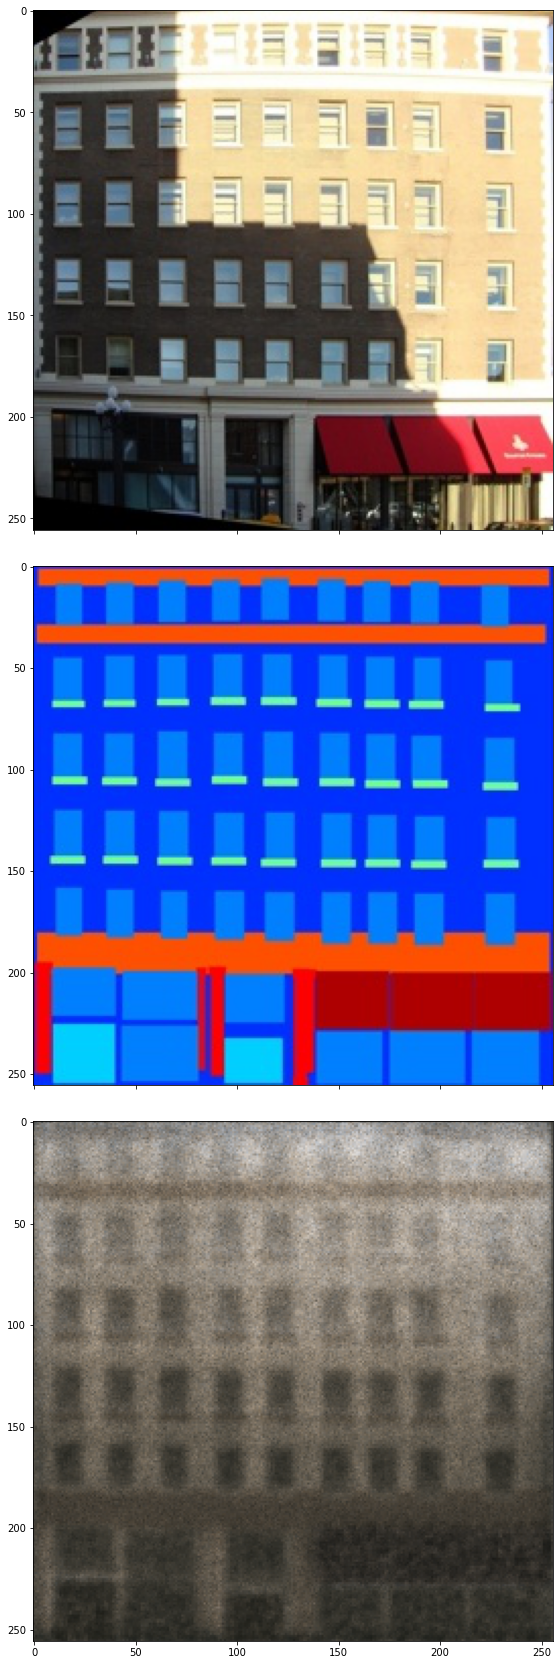

Epoch 11


  0%|          | 0/400 [00:00<?, ?it/s]

Generator loss: 17.009758491516113 Discriminator loss: 50.0
Epoch 12


  0%|          | 0/400 [00:00<?, ?it/s]

Generator loss: 16.91286682844162 Discriminator loss: 50.0
Epoch 13


  0%|          | 0/400 [00:00<?, ?it/s]

Generator loss: 16.820876927375792 Discriminator loss: 50.0
Epoch 14


  0%|          | 0/400 [00:00<?, ?it/s]

Generator loss: 16.55470067024231 Discriminator loss: 50.0
Epoch 15


  0%|          | 0/400 [00:00<?, ?it/s]

Generator loss: 16.191890475749968 Discriminator loss: 50.0
Epoch 16


  0%|          | 0/400 [00:00<?, ?it/s]

Generator loss: 16.103046610355378 Discriminator loss: 50.0
Epoch 17


  0%|          | 0/400 [00:00<?, ?it/s]

Generator loss: 15.740329666137695 Discriminator loss: 50.0
Epoch 18


  0%|          | 0/400 [00:00<?, ?it/s]

Generator loss: 15.465065591335296 Discriminator loss: 50.0
Epoch 19


  0%|          | 0/400 [00:00<?, ?it/s]

Generator loss: 15.345223898887633 Discriminator loss: 50.0
Epoch 20


  0%|          | 0/400 [00:00<?, ?it/s]

Generator loss: 15.301214165687561 Discriminator loss: 50.0


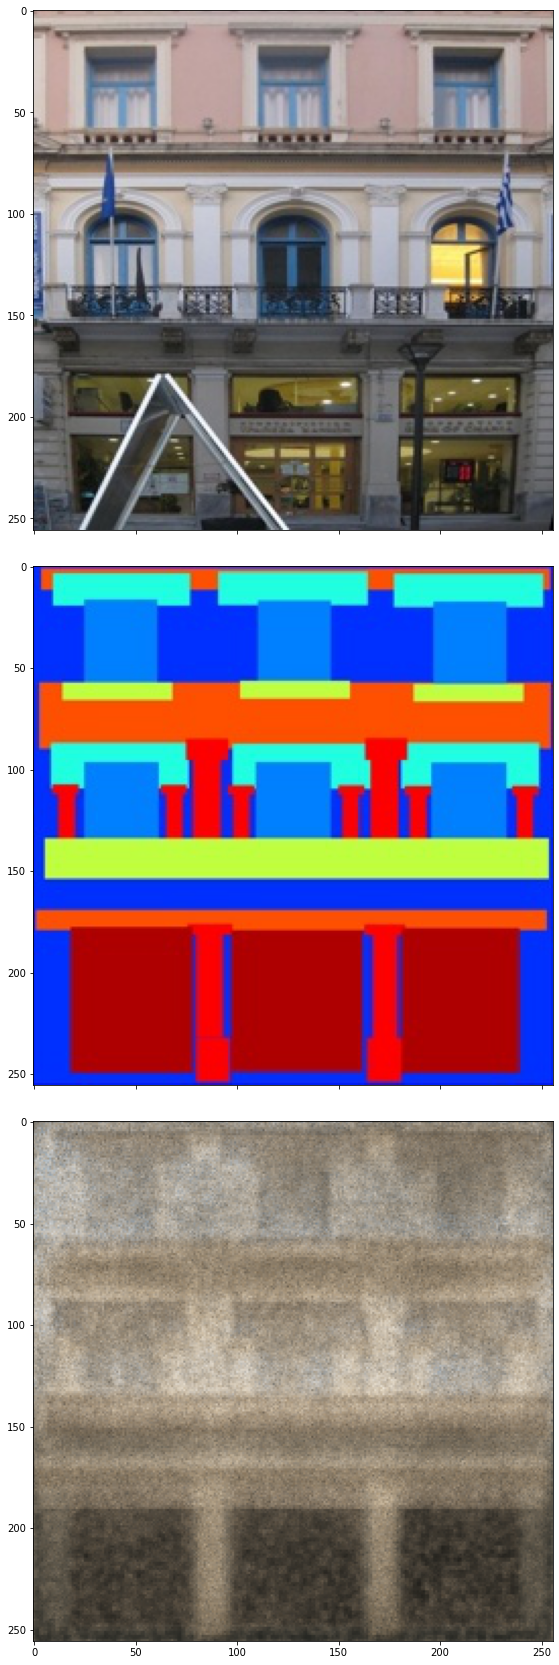

Epoch 21


  0%|          | 0/400 [00:00<?, ?it/s]

Generator loss: 15.02508779525757 Discriminator loss: 50.0
Epoch 22


  0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}')

    d_losses = []
    g_losses = []
    netG.train()
    netD.train()
    for batch in tqdm.notebook.tqdm(train_dataloader):
        images, masks = batch
        images = images.to(device)
        masks = masks.to(device)
        
        valid = Variable(torch.Tensor(images.size(0), 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.Tensor(images.size(0), 1).fill_(0.0), requires_grad=False).to(device)
        
        optimizer_G.zero_grad()
        generated = netG(masks)
        g_loss = F.binary_cross_entropy(netD(generated, masks), valid) + l1_lambda * F.l1_loss(generated, images)
        g_loss.backward()
        optimizer_G.step()

        optimizer_D.zero_grad()

        real_loss = F.binary_cross_entropy(netD(images, masks), valid)
        fake_loss = F.binary_cross_entropy(netD(generated.detach(), masks), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()
        
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        
    print(f'Generator loss: {np.mean(g_losses)} Discriminator loss: {np.mean(d_losses)}')    
    if (epoch + 1) % 10 == 0:
        netG.eval()
        plot_images(images, masks, generated.detach())